## RNN-딥러닝을 이용한 문서 분류

딥러닝은 카운트벡터와 달리 **단어의 순서**를 반영해 문맥을 이해하는 방식으로 작동한다.
RNN은 문장을 이해하기 위해 단어의 순서를 고려하는 가장 직관적인 모델이다.

### Q1. 왜 RNN인가?
순환신경망이라고 부르는 RNN(Recurrent Neural Networks)은 시계열 데이터를 다루기 위한 모형으로 알려져 있다.
일정한 시간 간격으로 측정한 시계열 데이터에는 **특정한 규칙성이나 패턴이 있는 경우**에, 이러한 패턴을 기반으로 다음 값을 예측하는 것이 가능하다.
시계열 예측모형에서 가장 중요한 것은 **앞의 값들이 뒤의 값에 영향을 미친다는 것**이다.

#### Q2. RNN이 문서 분류에 적합한 이유
RNN이 앞에서부터 순차적으로 미치는 영향을 계속 축적하는 모형이다.
문맥은 단어들의 순서를 통해서 형성되는데, RNN은 구조상 이와 같은 문맥을 파악하기에 좋은 모형이다.
앞 단어로부터 문맥에 관한 정보가 마지막 노드까지 순차적으로 축적되면 그 정보를 이용해 문서를 분류하면 된다.
I/ am/ so/ happy → 긍정, 부정 파악
**최근에 RNN보다 더 좋은 모형이 나왔고, RNN은 경사소실 문제가 심각하기 때문에 좋은 모형은 아니다.**

### word-embedding
딥러닝 모형에 단어를 입력으로 사용하기 위해서는 one-hot-vector로 표현해야 하고 이를 다시 짧은 길이의 밀집벡터로 변환해야 한다.
딥러닝에서는 기본적으로 문서를 단어의 sequence로 표현하고, 각 단어들은 고정된 길이의 벡터가 되어야 한다.

dummy-변수 : 0과 1만으로 범주형 데이터를 표현한다.
one-hot-encoding : 범주형 데이터를 벡터 형태의 연속된 수치로 변환한 것 (이 결과는 one-hot-vector임)

embedding : 희소벡터 생성을 막기 위해, 범주형 데이터를 연속적인 값을 갖는, 상대적으로 **작은 크기의 벡터로 변환**하는 작업을 의미한다. (축소)

#### Q. embedding을 하는 이유
1 . 차원이 큰 원핫 벡터를 그대로 쓰면 연산이 비효율적이다.
2 . 대상간의 의미적 유사도를 계산할 수 있다. (모든 데이터 간의 거리가 동일하게 유지된다.)
3 . 단어가 의미적인 정보를 함축함으로써 연산이 가능해질 수 있다. → 연관있는 단어들의 관계를 이용해 연산을 수행하여 추론을 한다.
4 . 전이학습이 가능하다. (학습된 가중치 행렬을 이용해 밀집 벡터를 계산한다. → 시간 절약)

#### 1. RNN을 이용한 문서분류 - NLTK 영화 리뷰 감성분석

감성분석은 긍정과 부정 중 하나를 선택하는 이진 분류 문제

최종 출력단 크기 : 1
활성화 함수 : sigmoid
손실함수 : binary crossentropy

In [3]:
##데이터 준비
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids()

reviews = [movie_reviews.raw(fileid) for fileid in fileids]

categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print("#Reviews count:", len(reviews))
print("Length of the first review:", len(reviews[0]))
print("Labels:", set(categories))

#Reviews count: 2000
Length of the first review: 4043
Labels: {'pos', 'neg'}


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 #사용할 단어의 수

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
# oov_token : 사전에 없는 단어들(max_words에 포함X)를 공통 단어로 표기할 것인가?
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')

tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

#만들어진 단어 인덱스를 이용해 문서들을 변환
X = tokenizer.texts_to_sequences(reviews)

#몇개의 인덱스가 변환되었는지 알려주는듯
print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [14]:
#각 단어들이 몇번째 인덱스에 해당되는가?
import numpy as np
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [15]:
#시퀀스의 크기가 maxlen보다 크면 남는 부분을 자른다. - truncating 매개변수 사용
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500 #문서 안의 단어의 수 500개로 제한

# 'pre' : 앞을 자르고 뒷부분을 사용 (post는 반대)
X = pad_sequences(X, maxlen = max_len, truncating = 'pre')

In [17]:
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


### 일반적인 신경망 모형

구성 : embedding layer, flatten layer, dense layer

embedding layer : RNN을 위해 만든 입력을 받아 one-hot-encoding과 word-embedding을 수행하는 layer
flatten layer : 2차원 행렬의 형태로 된 값을 펼쳐서 1차원 벡터로 변환한다.
dense layer : 모든 노드들이 연결되는 밀집 층

In [29]:
# 케라스 모형 생성 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([ #순차적 모형
    Embedding(max_words, 32, input_length=max_len), #word embedding layer 생성
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(), # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])

model.summary() #모델의 요약정보 출력

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 16001     
                                                                 
Total params: 336001 (1.28 MB)
Trainable params: 336001 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# 학습을 수행
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 8ms/step - loss: 0.6908 - acc: 0.5289 - val_loss: 0.6908 - val_acc: 0.4656
Epoch 2/10
40/40 [==============================] - 0s 6ms/step - loss: 0.6122 - acc: 0.8945 - val_loss: 0.6832 - val_acc: 0.5156
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 0.5074 - acc: 0.9648 - val_loss: 0.6678 - val_acc: 0.5437
Epoch 4/10
40/40 [==============================] - 0s 6ms/step - loss: 0.3750 - acc: 0.9875 - val_loss: 0.6454 - val_acc: 0.6156
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 0.2474 - acc: 0.9969 - val_loss: 0.6240 - val_acc: 0.6438
Epoch 6/10
40/40 [==============================] - 0s 6ms/step - loss: 0.1483 - acc: 0.9984 - val_loss: 0.6144 - val_acc: 0.6250
Epoch 7/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0839 - acc: 1.0000 - val_loss: 0.6064 - val_acc: 0.6281
Epoch 8/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0456 - acc: 1.00

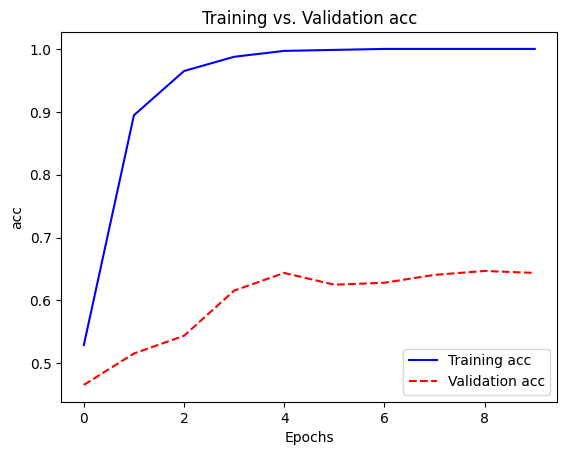

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'acc')

In [32]:
#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

13/13 [==============================] - 0s 2ms/step - loss: 0.5908 - acc: 0.7075
#Test accuracy:0.707


In [ ]:
#### 문서의 순서정보를 활용하는 RNN 기반 문서 분류